In [2]:
'''
1. データの読み込みと前処理
'''
import os
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ダウンロード先のディレクトリ
root = './data'

# トランスフォーマーオブジェクトを生成
transform_train = transforms.Compose(
    [transforms.ToTensor(), # Tensorオブジェクトに変換
     transforms.Normalize((0.5), (0.5)) # 平均0.5、標準偏差0.5で正規化
     ])

transform_val = transforms.Compose(
     [transforms.ToTensor(), # Tensorオブジェクトに変換
     transforms.Normalize((0.5), (0.5)) # 平均0.5、標準偏差0.5で正規化
     ])

# 訓練用データの読み込み
f_mnist_train = datasets.CIFAR10(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=True,    # 訓練データを指定
    transform=transform_train) # トランスフォーマーオブジェクトを指定

# テスト用データの読み込み
f_mnist_test = datasets.CIFAR10(
    root=root,     # データの保存先のディレクトリ
    download=True, # ダウンロードを許可
    train=False,   # テストデータを指定
    transform=transform_val) # トランスフォーマーオブジェクトを指定

# ミニバッチのサイズ
batch_size = 64
# 訓練用のデータローダー
train_dataloader = DataLoader(f_mnist_train, # 訓練データ
                              batch_size=batch_size, # ミニバッチのサイズ
                              shuffle=True) # シャッフルして抽出
# テスト用のデータローダー
test_dataloader = DataLoader(f_mnist_test, # テストデータ
                             batch_size=batch_size, # ミニバッチのサイズ
                             shuffle=False) # シャッフルして抽出

# データローダーが返すミニバッチの先頭データの形状を出力
for (x, t) in train_dataloader: # 訓練データ
    print(x.shape)
    print(t.shape)
    break

for (x, t) in test_dataloader: # テストデータ
    print(x.shape)
    print(t.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])
torch.Size([64])
torch.Size([64, 3, 32, 32])
torch.Size([64])


In [3]:
'''
2. モデルの定義
'''
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    '''畳み込みニューラルネットワーク
    
    Attributes:
      conv1(Conv2d): 畳み込み層
      conv2(Conv2d): 畳み込み層
      pool1(MaxPool2d): プーリング層
      dropput1(Dropout2d): ドロップアウト
      conv2D_3(Conv2d): 畳み込み層
      conv2D_4(Conv2d): 畳み込み層
      pool2(MaxPool2d): プーリング層
      dropput2(Dropout2d): ドロップアウト
      fc1(Linear): 全結合層
      dropput3(Dropout): ドロップアウト
      fc2(Linear): 全結合層
    '''
    def __init__(self):
        '''モデルの初期化を行う          
        '''
        # スーパークラスの__init__()を実行
        super().__init__()

        # 第1層: 畳み込み層1
        # (バッチサイズ,3,32,32) -> (バッチサイズ,32,32,32)
        self.conv1 = nn.Conv2d(in_channels=3,   # 入力チャネル数
                               out_channels=32, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=True,    # パディングを行う
                               padding_mode='zeros')

        # 第2層: 畳み込み層2
        # (バッチサイズ,32,32,32) ->(バッチサイズ,32,32,32)
        self.conv2 = nn.Conv2d(in_channels=32,  # 入力チャネル数
                               out_channels=32, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=True,    # パディングを行う
                               padding_mode='zeros')
       
        # 第3層: プーリング層1
        # (バッチサイズ,32,32,32) -> (バッチサイズ,32,16,16)
        self.pool1 = nn.MaxPool2d(2, 2)
        # ドロップアウト1: 50%
        self.dropout1 = nn.Dropout2d(0.5)

        # 第4層: 畳み込み層3
        # (バッチサイズ,32,16,16) ->(バッチサイズ,64,16,16)
        self.conv3 = nn.Conv2d(in_channels=32,  # 入力チャネル数
                               out_channels=64, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=True,    # パディングを行う
                               padding_mode='zeros')

        # 第5層: 畳み込み層4
        # (バッチサイズ,64,16,16) ->(バッチサイズ,64,16,16)
        self.conv4 = nn.Conv2d(in_channels=64,  # 入力チャネル数
                               out_channels=64, # 出力チャネル数
                               kernel_size=3,   # フィルターサイズ
                               padding=True,    # パディングを行う
                               padding_mode='zeros')

        # 第6層: プーリング層2
        # (バッチサイズ,64,16,16) ->(バッチサイズ,64,8,8)
        self.pool2 = nn.MaxPool2d(2, 2)
        # ドロップアウト2: 50%
        self.dropout2 = nn.Dropout2d(0.5)

        # 第10層: 全結合層1
        # (バッチサイズ,4096) -> (バッチサイズ,512)
        self.fc1 = nn.Linear(64*8*8, 512)
        # ドロップアウト3: 50%
        self.dropout3 = nn.Dropout(0.5)

        # 第11層: 出力層
        # (バッチサイズ,512) -> (バッチサイズ,10)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        '''MLPの順伝播処理を行う
        
        Parameters:
          x(ndarray(float32)):訓練データ、または検証データ
          
        Returns(float32):
          出力層からの出力値    
        '''
        x = F.relu(self.conv1(x))             # conv1
        x = self.pool1(F.relu(self.conv2(x))) # conv2 ->pool1
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))             # conv3
        x = self.pool2( F.relu(self.conv4(x))) # conv4 ->pool2
        x = self.dropout2(x)
        x = x.view(-1, 64*8*8)                # フラット化
        x = F.relu(self.fc1(x))               # fc1
        x = self.dropout3(x)
        x = self.fc2(x)                       # fc2
        return x

In [4]:
'''
3. モデルの生成
'''
import torch

# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# モデルオブジェクトを生成し、使用可能なデバイスを設定する
model = CNN().to(device)

model # モデルの構造を出力

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [5]:
'''
4. 損失関数とオプティマイザーの生成
'''
import torch.optim

# クロスエントロピー誤差のオブジェクトを生成
criterion = nn.CrossEntropyLoss()
# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
'''
5. 勾配降下アルゴリズムによるパラメーターの更新処理
'''
def train_step(x, t):
    '''バックプロパゲーションによるパラメーター更新を行う
    
    Parameters: x: 訓練データ
                t: 正解ラベル                
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.train()    # モデルを訓練(学習)モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得
    optimizer.zero_grad() # 勾配を0で初期化（累積してしまうため）
    loss.backward()  # 逆伝播の処理(自動微分による勾配計算)
    optimizer.step() # 勾配降下法の更新式を適用してバイアス、重みを更新

    return loss, preds 

In [7]:
'''
6. モデルの評価を行う関数
'''
def test_step(x, t):
    '''テストデータを入力して損失と予測値を返す
    
    Parameters: x: テストデータ
                t: 正解ラベル
    Returns:
      MLPの出力と正解ラベルのクロスエントロピー誤差
    '''
    model.eval()     # モデルを評価モードにする
    preds = model(x) # モデルの出力を取得
    loss = criterion(preds, t) # 出力と正解ラベルの誤差から損失を取得

    return loss, preds 

In [8]:
%%time
'''
7.モデルを使用して学習する
'''
from sklearn.metrics import accuracy_score

# エポック数
epochs = 120
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'loss':[],'accuracy':[], 'test_loss':[], 'test_accuracy':[]}

# 収束が停滞したら学習率を減衰するスケジューラー
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,   # オプティマイザーを指定
    mode='max',  # 監視対象は最大値
    factor=0.5,  # 学習率を減衰する割合
    patience=10, # 監視対象のエポック数
    min_lr=0.0001, # 最小学習率
    verbose=True # 学習率を減衰した場合に通知する
    )

# 学習を行う
for epoch in range(epochs):
    train_loss = 0. # 訓練1エポックあたりの損失を保持する変数
    train_acc = 0.  # 訓練1エポックごとの精度を保持する変数
    test_loss = 0.  # 評価1エポックごとの損失を保持する変数
    test_acc = 0.   # 評価1エポックごとの精度を保持する変数

    # 1ステップにおける訓練用ミニバッチを使用した学習
    for (x, t) in train_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t) # 損失と予測値を取得
        train_loss += loss.item()      # ステップごとの損失を加算
        train_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 1ステップにおけるテストデータのミニバッチを使用した評価
    for (x, t) in test_dataloader:
        # torch.Tensorオブジェクトにデバイスを割り当てる
        x, t = x.to(device), t.to(device)
        loss, preds = test_step(x, t) # 損失と予測値を取得
        test_loss += loss.item()       # ステップごとの損失を加算
        test_acc += accuracy_score(
            t.tolist(),
            preds.argmax(dim=-1).tolist()
        )                              # ステップごとの精度を加算

    # 訓練時の損失の平均値を取得
    avg_train_loss = train_loss / len(train_dataloader)
    # 訓練時の精度の平均値を取得
    avg_train_acc = train_acc / len(train_dataloader)
    # 検証時の損失の平均値を取得
    avg_test_loss = test_loss / len(test_dataloader)
    # 検証時の精度の平均値を取得
    avg_test_acc = test_acc / len(test_dataloader)

    # 訓練データの履歴を保存する
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)
    # テストデータの履歴を保存する
    history['test_loss'].append(avg_test_loss)
    history['test_accuracy'].append(avg_test_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc: {:.4} val_loss: {:.4} val_acc: {:.4}'.format(
                epoch+1,
                avg_train_loss, # 訓練データの損失を出力
                avg_train_acc,  # 訓練データの精度を出力
                avg_test_loss,  # テストデータの損失を出力
                avg_test_acc    # テストデータの精度を出力
    ))
    # スケジューラー、テストデータの精度を監視する
    scheduler.step(avg_test_acc)

TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (Tensor, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


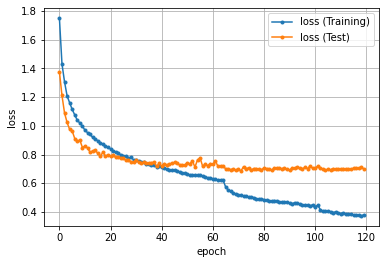

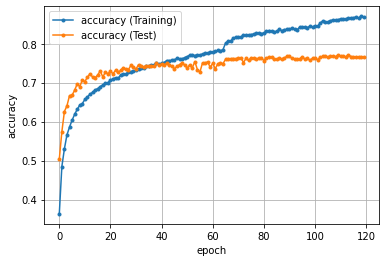

In [ ]:
'''
8. 損失と精度をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

# 学習結果（損失）のグラフを描画
plt.plot(history['loss'],
         marker='.',
         label='loss (Training)')
plt.plot(history['test_loss'],
         marker='.',
         label='loss (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 学習結果（精度）のグラフを描画
plt.plot(history['accuracy'],
         marker='.',
         label='accuracy (Training)')
plt.plot(history['test_accuracy'],
         marker='.',
         label='accuracy (Test)')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()